## Explorations with Gibbs Sampling Using a CRP DP Prior on a Mixture of Gaussians

Dirichlet process prior on mixture of gaussians with base distribution $\mu \sim N(0, 5I)$ and $x \sim N(\mu, I)$. Uses CRP to assign cluster membership. Uses Gibbs sampling with MAP estimates of cluster membership and cluster $\mu$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

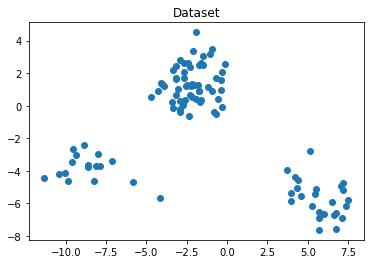

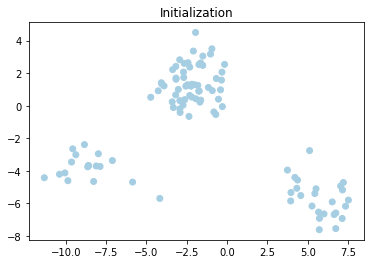

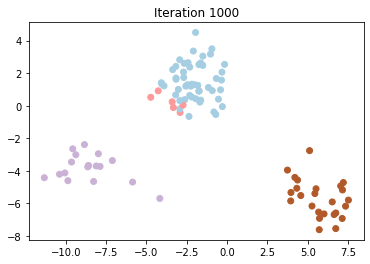

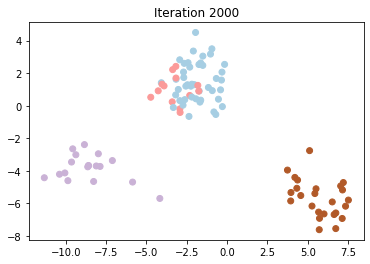

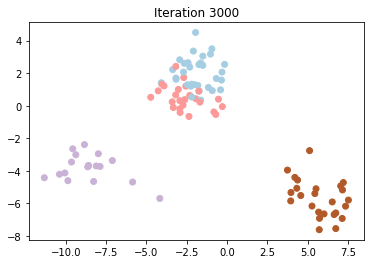

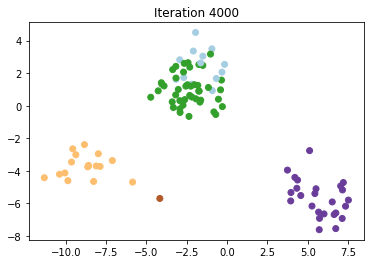

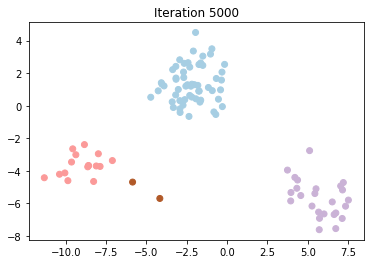

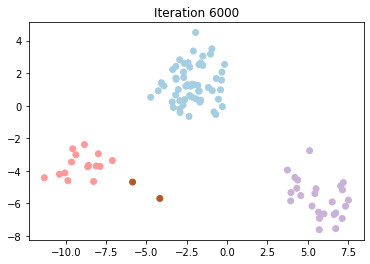

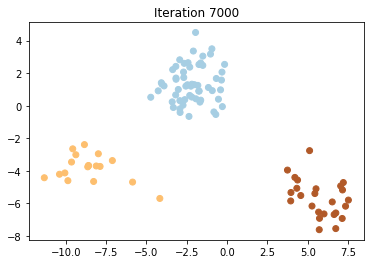

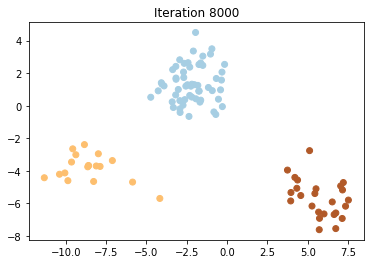

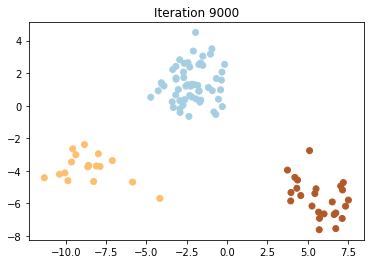

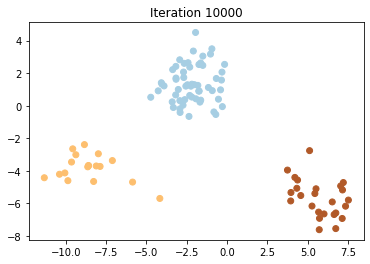

In [2]:
class CRP:
    def __init__(self, alpha=0.9):
        self.table_idx = 0
        self.alpha = alpha
        self.tables = {}
        self.idx2table = {}
        self.points = 0
        
    def _new_table(self, i):
        assignment = self.table_idx
        self.table_idx += 1
        self.tables[assignment] = [i]
        self.idx2table[i] = assignment
        return assignment
    
    def color(self):
        table2idx = {table: idx for idx, table in enumerate(sorted(self.tables.keys()))}
        return [table2idx[table] for idx, table in sorted(self.idx2table.items())]
        
    def sample(self):
        i = self.points
        self.points += 1
        if len(self.tables) == 0:
            return self._new_table(i)
        else:
            table_idces, sizes = zip(*[(table_idx, len(table)) for table_idx, table in sorted(self.tables.items())])
            sizes = list(sizes)
            table_idces = list(table_idces)
            p = np.array(sizes + [self.alpha]) / (sum(sizes) + self.alpha)
            assignment = np.random.choice(len(p), p=p)
            if assignment == len(table_idces):
                return self._new_table(i)
            else:
                table = table_idces[assignment]
                self.tables[table].append(i)
                self.idx2table[i] = table
                return table
            
    def table_of(self, i):
        return self.idx2table[i]
    
    def resample(self, i, likelihood_given_table, likelihood_given_new):
        table_idx = self.idx2table[i]
        del self.idx2table[i]
        table = self.tables[table_idx]
        if len(table) == 1:
            del self.tables[table_idx]
        else:
            table.pop(table.index(i))
        if len(self.tables) == 0:
            return self._new_table(i)
        else:
            table_idces, sizes = zip(*[(table_idx, len(table)) for table_idx, table in sorted(self.tables.items())])
            sizes = list(sizes)
            table_idces = list(table_idces)
            likelihoods = np.array([likelihood_given_table[table] for table in table_idces] + [likelihood_given_new])
            priors = np.array(sizes + [self.alpha]) / (sum(sizes) + self.alpha)
            unnormalized_posterior = likelihoods * priors
            posterior = unnormalized_posterior / unnormalized_posterior.sum()
            assignment = np.random.choice(len(posterior), p=posterior)
            if assignment == len(table_idces):
                return self._new_table(i)
            else:
                table = table_idces[assignment]
                self.tables[table].append(i)
                self.idx2table[i] = table
                return table

def generate_X():
    N = 100
    alpha = 0.9
    
    crp = CRP()
    tables = [crp.sample() for i in range(N)]
    
    meals_mu = np.random.normal(0, 5, size=[len(crp.tables), 2])
    
    X = []
    for i in range(N):
        table = tables[i]
        x = np.random.normal(meals_mu[table], 1)
        X.append(x)
    X = np.stack(X)
    return X

def gibbs(X):
    # Initialization
    crp = CRP(alpha=0.01) #alpha=0.000000001)
    N = X.shape[0]
    tables = [crp.sample() for i in range(N)]
    
    meals_mu = {
        table: np.random.normal(0, 5, size=[2])
        for table in crp.tables
    }
    
    plt.scatter(X[:,0], X[:,1], c=tables, cmap="Paired")
    plt.title("Initialization")
    plt.show()
    
    for t in range(10000):
        param = np.random.choice(N + len(crp.tables))
        if param < N:
            i = param
            x = X[i]
            likelihood_given_table = {}
            for table in crp.tables:
                mu = meals_mu[table]
                likelihood_given_table[table] = scipy.stats.norm.pdf(x, mu, 1).prod()
            new_mu = np.random.normal(0, 5, size=[2])
            likelihood_given_new = scipy.stats.norm.pdf(x, new_mu, 1).prod()
            table = crp.resample(i, likelihood_given_table, likelihood_given_new)
            if table not in meals_mu:
                meals_mu[table] = new_mu
        else:
            table_idx = param - N
            table_name = sorted(crp.tables)[table_idx]
            table = crp.tables[table_name]
            mu = meals_mu[table_name]
            points = X[table]
            new_mu = np.sum(points, axis=0) / (1 / 25 + points.shape[0])
            meals_mu[table_name] = new_mu
        if (t + 1) % 1000 == 0:
            plt.scatter(X[:,0], X[:,1], c=crp.color(), cmap="Paired")
            plt.title("Iteration %d" % (t + 1))
            plt.show()
    

np.random.seed(44)
X = generate_X()
plt.scatter(X[:,0], X[:,1])
plt.title("Dataset")
plt.show()
gibbs(X)